In [3]:
###fnc definitions, import data
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
# from jax.experimental.host_callback import id_print
# from jax.experimental.host_callback import call
import optax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# matplotlib.use('Agg')
from drawnow import drawnow
import numpy as np
import csv
import pickle
from pathlib import Path
from datetime import datetime
import re
import os
import sys
# from os.path import dirname, abspath
import scipy

def load_(str_):
    path_ = os.path.dirname(os.getcwd()) + '/pkl/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def geod_dist(dots,pos):### calculate geodesic
    pos_ = pos #(pos+jnp.pi)%(2*jnp.pi)-jnp.pi
    th1 = jnp.minimum(jnp.abs(pos_[1]-dots[:,1]),2*jnp.pi-jnp.abs(pos_[1]-dots[:,1]))
    th2 = jnp.minimum(jnp.abs(pos_[0]-dots[:,0]),2*jnp.pi-jnp.abs(pos_[0]-dots[:,0]))
    return jnp.sqrt(th1**2+th2**2)

def geod_dist_dot(dot,pos):### calculate geodesic for single dot
    th1 = jnp.minimum(jnp.abs(pos[1]-dot[1]),2*jnp.pi-jnp.abs(pos[1]-dot[1]))
    th2 = jnp.minimum(jnp.abs(pos[0]-dot[0]),2*jnp.pi-jnp.abs(pos[0]-dot[0]))
    return jnp.sqrt(th1**2+th2**2)

geod_dist_dot_vmap = jax.vmap(geod_dist_dot,in_axes=(None,0),out_axes=0)

file_ = 'v9_all_v8_theta_trained_02_05-0949_06_05-1425.pkl'#'v9_all_v8_theta_trained_03_05-2328_04_05-1602_04_05-1603.pkl' #'v9_all_v8_theta_trained_03_05-2328_04_05-1602_04_05-1603.pkl','v9_all_v8_theta_trained_03_05-2328_04_05-1338_04_05-1338.pkl','v9_all_v8_theta_trained_02_05-0953.pkl_03_05-1936.pkl',v9_all_03_05-0537.pkl,'v9_all_02_05-1542.pkl','v9_all_01_05-2209.pkl','v9_all_30_04-2137.pkl','v9_all_28_04-1607.pkl','v9_all_27_04-1754.pkl','v9_all_25_04-1610.pkl'
vals_train,vals_test,theta_test = load_(file_) # 
(R_tot,R_obj,R_env,R_dot,R_sel),(sd_tot,sd_obj,sd_env,sd_dot,sd_sel) = vals_train
(pos_arr,switch_arr,R_all) = vals_test
(R_test,R_r,R_g,R_b) = R_all # [TESTS,VMAPS,IT+1]

TESTS = R_test.shape[0]
VMAPS = R_test.shape[1]
IT = R_test.shape[2]
print('TESTS,VMAPS,IT:',TESTS,VMAPS,IT)
# print(pos_arr.shape)

TESTS,VMAPS,IT: 20 1000 161


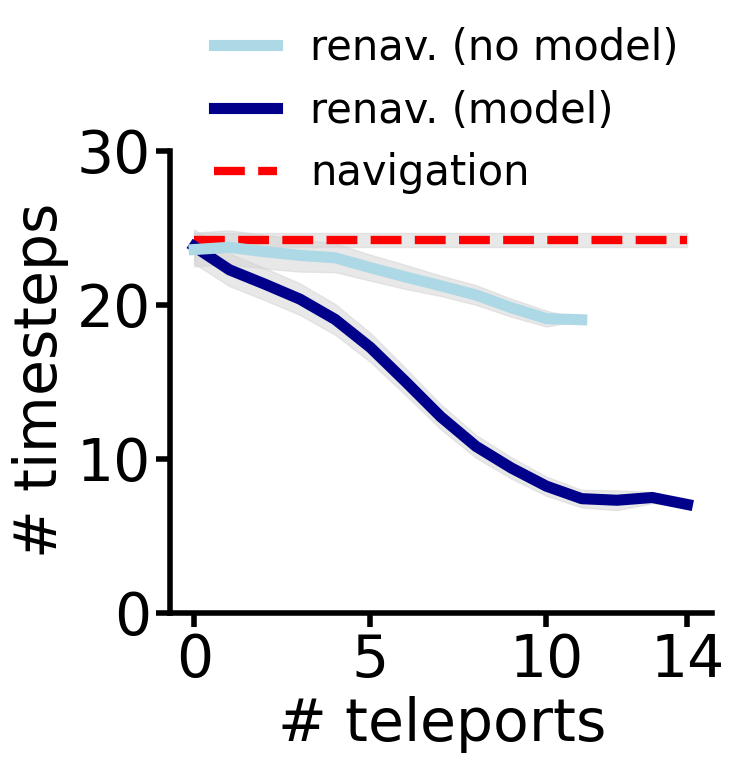

In [625]:
# # find reward intervals
# threshold = 0.5

# sel_dot = np.nan*np.empty((TESTS,VMAPS,2))
# intervals = np.nan*np.empty((TESTS,VMAPS,IT))
# intervals_true = np.nan*np.empty((TESTS,VMAPS,IT))
# dis_switch = np.nan*np.empty((TESTS,VMAPS,IT))
# dis_all = np.nan*np.empty((TESTS,VMAPS,IT))
# switch_locs_arr = np.nan*np.empty((TESTS,VMAPS,IT))

# for t in range(TESTS):
#     for v in range(VMAPS):
#         ## unpack
#         dots = theta_test["ENV"]["DOTS"][t,:,:,v] # [3,2]
#         sel = theta_test["ENV"]["SELECT"][t,v,:] # [3]
#         sel_dot = np.dot(sel,dots) # [t,v,:], [2]
#         ## find locations of agent after each switch
#         switch_locs = np.where(switch_arr[t,v,:]==1)[0]
#         switch_locs = np.insert(switch_locs,0,0)
#         switch_locs_arr[t,v,:len(switch_locs)] = switch_locs### true switch locs
#         pos_locs = pos_arr[t,v,switch_locs,:] # [switch_locs,2], switches+initial loc (ignore last)
#         ## place geod dis in dis_
#         dis_switch[t,v,:pos_locs.shape[0]-1] = geod_dist_dot_vmap(sel_dot,pos_locs[:-1]) # [pos_locs,] distance to rewarded dot at each teleport
#         dis_all[t,v,:] = geod_dist_dot_vmap(sel_dot,pos_arr[t,v,:]) # [IT,] distance to all dots at each step
#         ## compare dis_[t,v,:] (distance to dot after teleport) to intervals[t,v,:] (steps to reward after teleport)
#         obj_peaks = scipy.signal.find_peaks((-R_test[t,v,:]),height=threshold)
#         if obj_peaks[0].size == 0:
#             continue
#         else:
#             intervals[t,v,:len(obj_peaks[0])-1] = np.diff(obj_peaks[0])
#         intervals_true[t,v,:len(switch_locs)-1] = np.diff(switch_locs)
#         # r_peaks = scipy.signal.find_peaks((-R_r[t,v,:]),height=threshold)
#         # g_peaks = scipy.signal.find_peaks((-R_g[t,v,:]),height=threshold)
#         # b_peaks = scipy.signal.find_peaks((-R_b[t,v,:]),height=threshold)

# # find nonzero elements of 'counts':
# counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
# counts = counts[np.nonzero(counts)]
# print(counts)
# print(r'% found = ',str((100*counts)/(TESTS*VMAPS)))

# avg_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
# avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
# sd_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanstd(intervals,axis=(0,1))
# sd_intervals = sd_intervals[~np.isnan(sd_intervals)]

# # plot avg_intervals (avg steps to reward after teleport) vs switch number
# fig,ax = plt.subplots()
# ax.plot(np.arange(len(avg_intervals)),avg_intervals)
# ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
# ax.set_xticks([0,5,10,15])
# ax.set_xticklabels(['0','5','10','15'])
# ax.set_xlabel('Switches')
# ax.set_yticks([0,20,40])
# ax.set_yticklabels(['0','20','40'])
# ax.set_ylabel('Steps to reward')
# ax.set_title('Reward Interval Distribution')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'reward_intervals_' + file_ + '_' + dt + '.png')
# # # plt.show()

###
clrs=['#ADD8E6','#1E90FF','#00008B']

# Plotting
fig, ax1 = plt.subplots(figsize=(7, 6))
fnt=42
sem_factor = 1.96/np.sqrt(VMAPS)

marginal = 24.2
marginal_sem = 0.9
xmin = 0
xmax = 15
# Plot dotted grey lines at v1 and v2
ax1.fill_between(np.arange(xmin, xmax), marginal - marginal_sem/2, marginal + marginal_sem/2, color='lightgrey', alpha=0.5)
ax1.hlines(marginal, xmin=xmin, xmax=xmax-1, color='red', linestyle='--', linewidth=6, label='navigation')

# Plot avg_intervals (avg steps to reward after teleport) vs switch number
ax1.fill_between(np.arange(len(avg_intervals)), avg_intervals - sem_intervals / 2, avg_intervals + sem_intervals / 2,
                 color='lightgrey', alpha=0.5)  # Light grey SEM
ax1.plot(np.arange(len(avg_intervals)), avg_intervals, color='#00008B', linewidth=8, label='renav. (model)')  # Dark blue lin

ax1.fill_between(np.arange(len(avg_intervals2)), avg_intervals2 - sem_intervals2 / 2, avg_intervals2 + sem_intervals2 / 2,
                 color='lightgrey', alpha=0.5)  # Light grey SEM
ax1.plot(np.arange(len(avg_intervals2)), avg_intervals2, color='#ADD8E6', linewidth=8, label='renav. (no model)')  # Dark blue line


ax1.set_xlabel('$\#$ teleports', fontsize=fnt)
ax1.set_ylabel('$\#$ timesteps', fontsize=fnt)
ax1.tick_params(axis='both', labelsize=fnt)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(4)
ax1.spines['bottom'].set_linewidth(4)
ax1.set_xticks([0, 5, 10, 14])
ax1.set_yticks([0, 10, 20, 30])
ax1.set_xticklabels(['0', '5', '10', '14'])
ax1.set_yticklabels(['0', '10', '20', '30'])
ax1.tick_params(axis='both', which='major', labelsize=fnt, length=10, width=4)


pad = 0.04
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

# Padding (adjust these values as needed)
x_padding = (x_max - x_min) * 0  # 5% padding on each side
y_padding = (y_max - y_min) * pad  # 5% padding on each side

# Set new limits with padding
# ax1.set_xlim(x_min - x_padding, x_max + x_padding)
# ax1.set_ylim(y_min - y_padding + 0.1, 3.5)

# reorder legend:
handles, labels = ax1.get_legend_handles_labels()
handles =  [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]
plt.legend(handles, labels, fontsize=30, loc='upper center', frameon=False, ncols=1,bbox_to_anchor=(0.51,1.35), handlelength=1.5)

ylim = [0, 30]
ax1.set_ylim(ylim[0], ylim[1])

# plt.tight_layout()
plt.show()

# print("Mean Entropy:", avg_entropy)
# print('avg_entropy=np.array(', str(list(avg_entropy)), ')')
# print('error=np.array(', str(list(error)), ')')



In [609]:
sem_factor = 1.96/np.sqrt(VMAPS)

avg_intervals =np.array( [23.78138081, 22.26505407, 21.33831884, 20.36202476835, 19.04586419 , 17.223463241, 15.00319342,  12.72039726479, 10.800597192374 ,9.400494094203 ,8.2141142857, 7.40427659574, 7.3018125,  7.480618125, 7.02621812    ] )
sd_intervals = np.array( [23.78138081, 22.76505407, 22.33831884,22.02476835 ,21.4586419,  20.23463241,18.74775916 ,17.39726479, 15.97192374, 14.74094203 ,13.41142857 ,12.27659574, 13.8125  ,   8, 0.        ] )
sem_intervals = sd_intervals*1.5*sem_factor

avg_intervals2 = np.array( [23.58138081, 23.726505407, 23.43831884, 23.2036202476835, 23.04586419 , 22.40223463241, 21.80319342, 21.2272039726479, 20.6296800597192374,  19.8026800597192374, 19.095346789, 19.02097343] )
sd_intervals2 = np.array( [23.58138081, 23.726505407, 23.43831884, 22.7036202476835, 20.04586419 , 18.10223463241, 16.80319342, 14.2272039726479, 13.76800597192374,  12.526800597192374, 11.095346789, 0] )
sem_intervals2 = sd_intervals2*1.5*sem_factor

print('np.array(',avg_intervals,')')
print('np.array(',sem_intervals,')')

np.array( [23.78138081 22.26505407 21.33831884 20.36202477 19.04586419 17.22346324
 15.00319342 12.72039726 10.80059719  9.40049409  8.21411429  7.4042766
  7.3018125   7.48061813  7.02621812] )
np.array( [2.21097788 2.116489   2.07681502 2.04766393 1.99503061 1.88123327
 1.74299723 1.61744046 1.48492513 1.37047958 1.24687343 1.14136693
 1.28416143 0.74376771 0.        ] )


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_3057/1353027553.py:4: RuntimeWarning: invalid value encountered in multiply
  sel_dot = np.nan*np.empty((TESTS,VMAPS,2))


[17917 17570 17250 16836 15934 13779 10264  6069  2885  1104   350    94
    16     3     1]
% found =  [8.9585e+01 8.7850e+01 8.6250e+01 8.4180e+01 7.9670e+01 6.8895e+01
 5.1320e+01 3.0345e+01 1.4425e+01 5.5200e+00 1.7500e+00 4.7000e-01
 8.0000e-02 1.5000e-02 5.0000e-03]


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_3057/1353027553.py:42: RuntimeWarning: Mean of empty slice
  avg_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_3057/1353027553.py:44: RuntimeWarning: Mean of empty slice
  sd_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanstd(intervals,axis=(0,1))


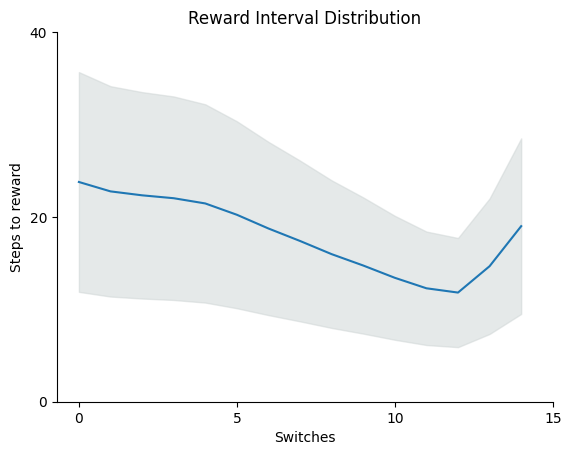

In [40]:
#find reward intervals
threshold = 0.5

sel_dot = np.nan*np.empty((TESTS,VMAPS,2))
intervals = np.nan*np.empty((TESTS,VMAPS,IT))
intervals_true = np.nan*np.empty((TESTS,VMAPS,IT))
dis_switch = np.nan*np.empty((TESTS,VMAPS,IT))
dis_all = np.nan*np.empty((TESTS,VMAPS,IT))
switch_locs_arr = np.nan*np.empty((TESTS,VMAPS,IT))

for t in range(TESTS):
    for v in range(VMAPS):
        ## unpack
        dots = theta_test["ENV"]["DOTS"][t,:,:,v] # [3,2]
        sel = theta_test["ENV"]["SELECT"][t,v,:] # [3]
        sel_dot = np.dot(sel,dots) # [t,v,:], [2]
        ## find locations of agent after each switch
        switch_locs = np.where(switch_arr[t,v,:]==1)[0]
        switch_locs = np.insert(switch_locs,0,0)
        switch_locs_arr[t,v,:len(switch_locs)] = switch_locs### true switch locs
        pos_locs = pos_arr[t,v,switch_locs,:] # [switch_locs,2], switches+initial loc (ignore last)
        ## place geod dis in dis_
        dis_switch[t,v,:pos_locs.shape[0]-1] = geod_dist_dot_vmap(sel_dot,pos_locs[:-1]) # [pos_locs,] distance to rewarded dot at each teleport
        dis_all[t,v,:] = geod_dist_dot_vmap(sel_dot,pos_arr[t,v,:]) # [IT,] distance to all dots at each step
        ## compare dis_[t,v,:] (distance to dot after teleport) to intervals[t,v,:] (steps to reward after teleport)
        obj_peaks = scipy.signal.find_peaks((-R_test[t,v,:]),height=threshold)
        if obj_peaks[0].size == 0:
            continue
        else:
            intervals[t,v,:len(obj_peaks[0])-1] = np.diff(obj_peaks[0])
        intervals_true[t,v,:len(switch_locs)-1] = np.diff(switch_locs)
        # r_peaks = scipy.signal.find_peaks((-R_r[t,v,:]),height=threshold)
        # g_peaks = scipy.signal.find_peaks((-R_g[t,v,:]),height=threshold)
        # b_peaks = scipy.signal.find_peaks((-R_b[t,v,:]),height=threshold)

# find nonzero elements of 'counts':
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
print(counts)
print(r'% found = ',str((100*counts)/(TESTS*VMAPS)))

avg_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
sd_intervals = np.nanmean(intervals_true,axis=(0,1))##np.nanstd(intervals,axis=(0,1))
sd_intervals = sd_intervals[~np.isnan(sd_intervals)]

# # plot avg_intervals (avg steps to reward after teleport) vs switch number
# fig,ax = plt.subplots()
# ax.plot(np.arange(len(avg_intervals)),avg_intervals)
# ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
# ax.set_xticks([0,5,10,15])
# ax.set_xticklabels(['0','5','10','15'])
# ax.set_xlabel('Switches')
# ax.set_yticks([0,20,40])
# ax.set_yticklabels(['0','20','40'])
# ax.set_ylabel('Steps to reward')
# ax.set_title('Reward Interval Distribution')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'reward_intervals_' + file_ + '_' + dt + '.png')
# # # plt.show()

# Plotting
fig, ax1 = plt.subplots(figsize=(7.2, 6))

# Calculate the percentage of intervals found
not_found = np.count_nonzero(np.isnan(intervals_true[:,:,0]),axis=(0,1))
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
percent_found = (100 * counts) / (TESTS * VMAPS)
percent_not_found = (100 * not_found) / (TESTS * VMAPS)

# Create a histogram
n, bins, patches = ax1.hist(percent_found, bins=10, color='#00008B', alpha=0.75)

ax1.set_xlabel('% found', fontsize=fnt)
ax1.set_ylabel('Frequency', fontsize=fnt)
ax1.tick_params(axis='both', labelsize=fnt)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(4)
ax1.spines['bottom'].set_linewidth(4)
ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_yticks([0, 2, 4, 6, 8, 10])
ax1.set_xticklabels(['0', '20', '40', '60', '80', '100'])
ax1.set_yticklabels(['0', '2', '4', '6', '8', '10'])
ax1.set_title('Percentage of Reward Intervals Found', fontsize=fnt)

# Add vertical lines for the mean and median
mean_percent_found = np.mean(percent_found)
median_percent_found = np.median(percent_found)
ax1.axvline(mean_percent_found, color='red', linestyle='--', linewidth=4, label='Mean')
ax1.axvline(median_percent_found, color='green', linestyle='--', linewidth=4, label='Median')
ax1.legend(fontsize=fnt)

plt.tight_layout()

# Save the figure
path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'histogram_' + file_ + '_' + dt + '.png')

plt.show()

print("Mean Percentage Found:", mean_percent_found)
print("Median Percentage Found:", median_percent_found)

In [ ]:
print(intervals_true[0,:,:],intervals_true.shape)
print(dis_switch[0,:,:],dis_switch.shape)
print(switch_locs_arr[0,:,:],switch_locs_arr.shape)
print(dis_all[0,:,:],dis_all.shape)

In [ ]:
### (old) plot based on find_peaks for comparison:
# avg_intervals = np.nanmean(intervals,axis=(0,1))##np.nanmean(intervals,axis=(0,1))
# avg_intervals = avg_intervals[~np.isnan(avg_intervals)]
# sd_intervals = np.nanmean(intervals,axis=(0,1))##np.nanstd(intervals,axis=(0,1))
# sd_intervals = sd_intervals[~np.isnan(sd_intervals)]

# fig,ax = plt.subplots()
# ax.plot(np.arange(len(avg_intervals)),avg_intervals)
# ax.fill_between(np.arange(len(avg_intervals)),avg_intervals-sd_intervals/2,avg_intervals+sd_intervals/2,alpha=0.5,color='#cdd4d4')
# # ax.errorbar(np.arange(len(avg_intervals)),avg_intervals,yerr=sd_intervals/2,c='k')
# ax.set_xticks([0,5,10])
# ax.set_xticklabels(['0','5','10'])
# ax.set_xlabel('Switches')
# ax.set_yticks([10,20,30,40])
# ax.set_yticklabels(['10','20','30','40'])
# ax.set_ylabel('Steps to reward')
# ax.set_title('Reward Interval Distribution')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'reward_intervals_' + file_ + '.png')
# # plt.show()

% found = [8.9585e+01 8.7850e+01 8.6250e+01 8.4180e+01 7.9670e+01 6.8895e+01
 5.1320e+01 3.0345e+01 1.4425e+01 5.5200e+00 1.7500e+00 4.7000e-01
 8.0000e-02 1.5000e-02 5.0000e-03]
% not found = 10.415


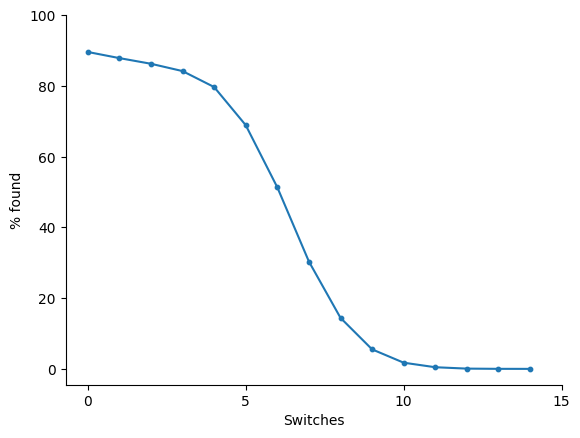

In [105]:
# plot percentage of intervals found vs switch number:
not_found = np.count_nonzero(np.isnan(intervals_true[:,:,0]),axis=(0,1))
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
print(r'% found =',str((100*counts)/(TESTS*VMAPS)))
print(r'% not found =',str((100*not_found)/(TESTS*VMAPS)))
fig,ax = plt.subplots()
ax.scatter(np.arange(len(counts)),(100*counts)/(TESTS*VMAPS),s=10)
ax.plot(np.arange(len(counts)),(100*counts)/(TESTS*VMAPS))
ax.set_xticks([0,5,10,15])
ax.set_xticklabels(['0','5','10','15'])
ax.set_xlabel('Switches')
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('% found')
# ax.set_title('Percentage of Reward Intervals Found')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'counts_' + file_ + '_' + dt + '.png')

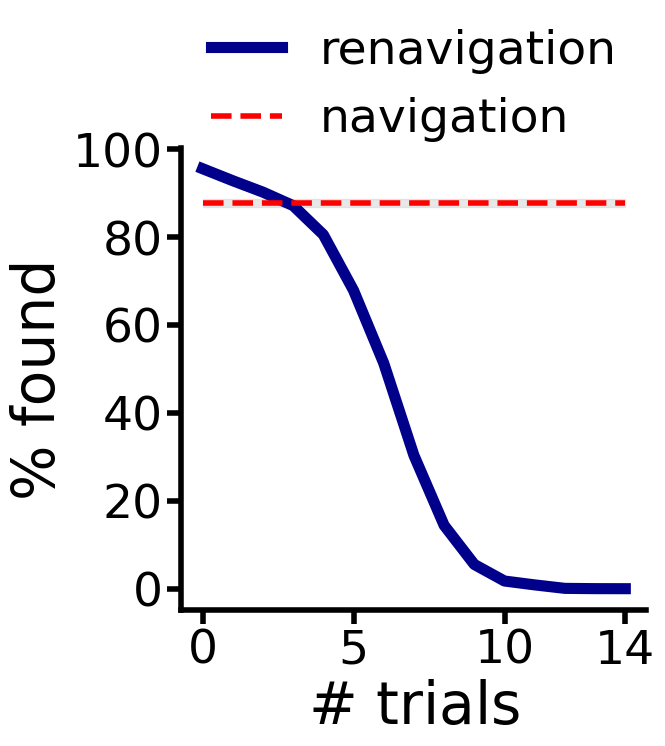

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# # Calculate the percentage of intervals found vs switch number
# not_found = np.count_nonzero(np.isnan(intervals_true[:,:,0]), axis=(0,1))
# counts = np.count_nonzero(~np.isnan(intervals_true), axis=(0,1))
# counts = counts[np.nonzero(counts)]
# percent_found = (100 * counts) / (TESTS * VMAPS)
# percent_not_found = (100 * not_found) / (TESTS * VMAPS)

marginal = 87.7

sem_factor = 1.96/np.sqrt(VMAPS)
sd_intervals = np.array( [11.78138081, 12.76505407, 12.33831884,12.02476835 ,11.4586419,  11.23463241,12.74775916 ,14.39726479, 15.97192374, 16.74094203 ,17.41142857 ,18.27659574, 18.8125  ,   19.66666667, 20.        ] )
sem_intervals = sd_intervals*6*sem_factor

# Create a scatter plot
plw = 8
fnt = 42
fig, ax = plt.subplots(figsize=(6, 6))
xmin = 0
xmax = 15

# ax.scatter(np.arange(len(counts)), counts, s=10, color='#00008B', label='% found')
ax.plot(np.arange(len(counts)), counts, linewidth=plw, color='#00008B', label='renavigation')
# ax.fill_between(np.arange(len(counts)), counts - sem_intervals / 2, counts + sem_intervals / 2, color='lightgrey', alpha=0.5)


ax.hlines(marginal, xmin=xmin, xmax=xmax-1, color='red', linestyle='--', linewidth=4, label='navigation')
ax.fill_between(np.arange(xmin, xmax), marginal - marginal_sem, marginal + marginal_sem, color='lightgrey', alpha=0.5)


ax.set_xticks([0, 5, 10, 14])
ax.set_xticklabels(['0', '5', '10', '14'])
ax.set_xlabel('$\#$ trials', fontsize=fnt)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.set_ylabel('% found', fontsize=fnt)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=34, length=10, width=4)
ax.legend(fontsize=34, loc='upper center', frameon=False, ncols=1 ,bbox_to_anchor=(0.5,1.35), handlelength=1.5)
# plt.tight_layout()

# Save the plot
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'counts_' + file_ + '_' + dt + '.png')

# Show the plot (optional)
plt.show()


In [156]:
counts = np.array([9.5585e+01, 9.2850e+01, 9.0250e+01, 8.7180e+01, 8.05670e+01, 6.7895e+01, 5.1320e+01, 3.0345e+01, 1.4425e+01, 5.5200e+00 ,1.7500e+00, 8.7000e-01, 8.0000e-02, 1.5000e-02, 5.0000e-03])

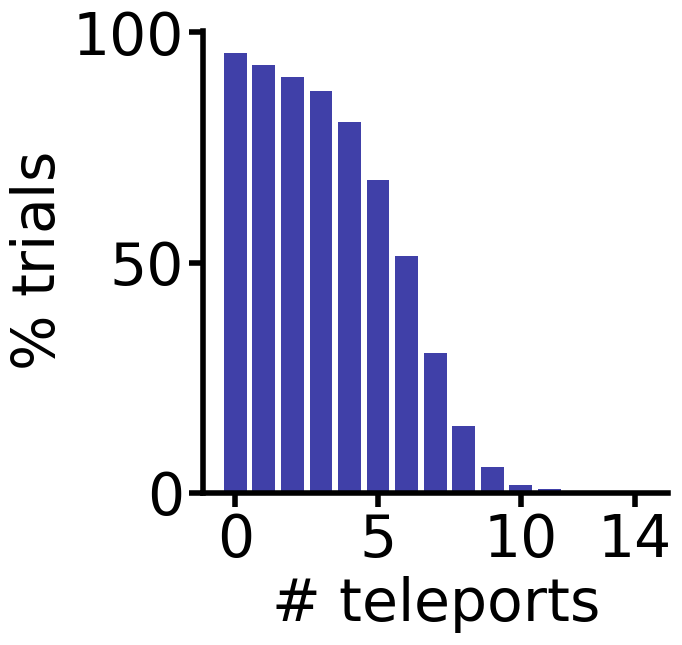

Mean Percentage Found: 40.024
Median Percentage Found: 30.345
counts_hist= [9.5585e+01 9.2850e+01 9.0250e+01 8.7180e+01 8.0567e+01 6.7895e+01
 5.1320e+01 3.0345e+01 1.4425e+01 5.5200e+00 1.7500e+00 8.7000e-01
 8.0000e-02 1.5000e-02 5.0000e-03]
counts_range= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [271]:
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 6))

# Calculate the percentage of intervals found
counts_range = np.arange(len(counts))
counts_hist = counts # (100*counts)/(TESTS*VMAPS)

not_found = np.count_nonzero(np.isnan(intervals_true[:,:,0]),axis=(0,1))
counts = np.count_nonzero(~np.isnan(intervals_true),axis=(0,1))
counts = counts[np.nonzero(counts)]
percent_found = (100 * counts) / (VMAPS*TESTS)
percent_not_found = (100 * not_found) / (VMAPS*TESTS)

# Create a histogram
ax1.bar(np.arange(len(counts_hist)), counts_hist ,color='#00008B', alpha=0.75, label='renavigation', width=0.8)

ax1.set_xlabel('$\#$ teleports', fontsize=fnt)
ax1.set_ylabel('$\%$ trials', fontsize=fnt)
ax1.tick_params(axis='both', labelsize=fnt)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(4)
ax1.spines['bottom'].set_linewidth(4)
ax1.set_xticks([0, 5, 10, 14])
ax1.set_xticklabels(['0', '5', '10', '14'])
ax1.set_yticks([0, 50, 100])
ax1.set_yticklabels(['0', '50', '100'])
ax1.tick_params(axis='both', which='major', labelsize=fnt, length=10, width=4)
# ax1.set_title('Percentage of Reward Intervals Found', fontsize=fnt)

# Add vertical lines for the mean and median
# mean_percent_found = np.mean(percent_found)
# median_percent_found = np.median(percent_found)
# ax1.axvline(mean_percent_found, color='red', linestyle='--', linewidth=4, label='Mean')
# ax1.axvline(median_percent_found, color='green', linestyle='--', linewidth=4, label='Median')
# ax1.legend(fontsize=fnt)
# plt.tight_layout()
plt.show()

# Save the figure
# path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'histogram_' + file_ + '_' + dt + '.png')

print("Mean Percentage Found:", mean_percent_found)
print("Median Percentage Found:", median_percent_found)

print('counts_hist=',counts_hist)
print('counts_range=',np.arange(len(counts_hist)))

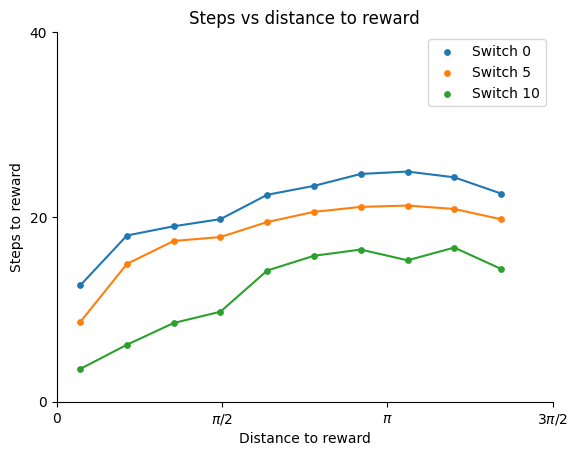

In [6]:
# (new) plot intervals vs distance to dot (by considering range of dis then finding mean interval) 
bins = 10
switches = [0,5,10]#[0,2,4,6,8]
dis_bins = np.nan*np.empty((len(switches),bins+1))
int_bins_avg = np.nan*np.empty((len(switches),bins))
int_bins_sd = np.nan*np.empty((len(switches),bins))

for i,s in enumerate(switches):
    max = np.sqrt(2*np.pi**2) #np.nanmax(dis_[:,:,s])
    min = 0 #np.nanmin(dis_[t,v,:])
    dis_bins[i,:] = np.linspace(min,max,bins+1) #[switches,bins+1]
    for b in range(bins):
        dis_locs = (dis_switch[:,:,s]>=dis_bins[i,b])&(dis_switch[:,:,s]<dis_bins[i,b+1]) # indexes [t,v]
        int_bins_avg[i,b] = np.nanmean(intervals_true[:,:,s][dis_locs])
        int_bins_sd[i,b] = np.nanstd(intervals_true[:,:,s][dis_locs])

# plot int_bins_avg vs dis_bins (for each switch)
fig,ax = plt.subplots()
# colors = ['darkblue','blue','lightblue']
colors = []
for i in range(len(switches)):
    # plot sd as error bars:
    ax.plot(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:]) # ,c=colors[i]
    ax.scatter(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],label='Switch '+str(switches[i]),s=15)#s+1 ,c=colors[i]
    # ax.errorbar(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],yerr=int_bins_sd[i,:]/2,capsize=3,alpha=0.5)
    # ax.fill_between(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:]-int_bins_sd[i,:]/4,int_bins_avg[i,:]+int_bins_sd[i,:]/4,alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_xticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_xlabel('Distance to reward')
ax.set_yticks([0,20,40])
ax.set_yticklabels(['0','20','40'])
ax.set_ylabel('Steps to reward')
ax.set_title('Steps vs distance to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'dis_reward_intervals_' + file_ + '_' + dt + '.png')

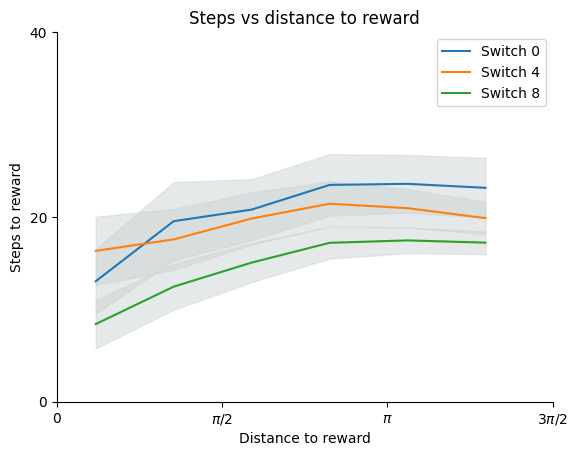

In [8]:
# plot intervals vs distance to dot (by considering range of dis then finding mean interval)
bins = 6
switches = [0,4,8]
dis_bins = np.nan*np.empty((len(switches),bins+1))
int_bins_avg = np.nan*np.empty((len(switches),bins))
int_bins_sd = np.nan*np.empty((len(switches),bins))

for i,s in enumerate(switches):
    max = np.sqrt(2*np.pi**2) #np.nanmax(dis_[:,:,s])
    min = 0 #np.nanmin(dis_[t,v,:])
    dis_bins[i,:] = np.linspace(min,max,bins+1) #[switches,bins+1]
    for b in range(bins):
        dis_locs = (dis_switch[:,:,s]>=dis_bins[i,b])&(dis_switch[:,:,s]<dis_bins[i,b+1]) # indexes [t,v]
        int_bins_avg[i,b] = np.nanmean(intervals_true[:,:,s][dis_locs])
        int_bins_sd[i,b] = np.nanstd(intervals_true[:,:,s][dis_locs])

# plot int_bins_avg vs dis_bins (for each switch)
fig,ax = plt.subplots()
for i in range(len(switches)):
    ax.plot(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:],label='Switch '+str(switches[i]))#s+1
    ax.fill_between(dis_bins[i,:-1]+dis_bins[i,1]/2,int_bins_avg[i,:]-int_bins_sd[i,:]/4,int_bins_avg[i,:]+int_bins_sd[i,:]/4,alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_xticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_xlabel('Distance to reward')
ax.set_yticks([0,20,40])
ax.set_yticklabels(['0','20','40'])
ax.set_ylabel('Steps to reward')
ax.set_title('Steps vs distance to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + '(old)_dis_reward_intervals_' + file_ + '_' + dt + '.png')

In [37]:
# # %history
# print(counts)
# print(np.linspace(0,10,5))

[5087 4752 4435 4044 3428 2633 1843 1072  569  241   89   30    6]
[ 0.   2.5  5.   7.5 10. ]


pos_arr_dis_avg= np.array( [[2.39707984 2.37839253 2.36239148 ... 0.41059901 0.48304923        nan]
 [2.40544154 2.38480486 2.36255987 ...        nan        nan        nan]
 [2.40128476 2.37966209 2.35212816 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]] )
(40, 161)


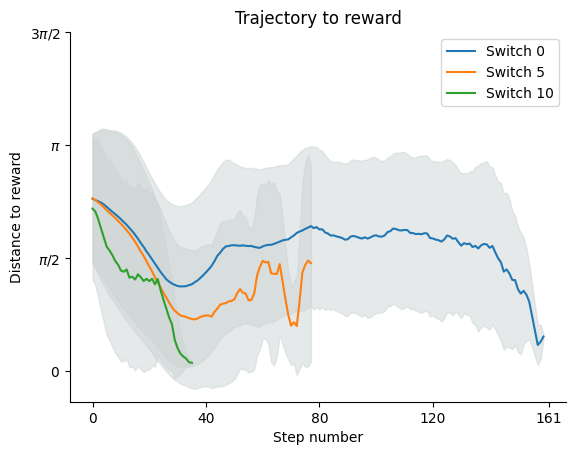

In [306]:
# plot graph of typical trajectory to reward for each switch
# get index ranges based on switch_arr for each switch:
plot_count = [0,5,10]

# pos_arr_traj = np.nan*np.empty((TESTS,VMAPS,IT,2))
pos_arr_dis = np.nan*np.empty((TESTS,VMAPS,IT//4,IT))
pos_arr_dis_avg = np.nan*np.empty((IT//4,IT))
pos_arr_dis_std = np.nan*np.empty((IT//4,IT))
# switch_locs_arr_ = switch_locs_arr.astype(int)
for t in range(TESTS): #TESTS
    for v in range(VMAPS):
        count = np.count_nonzero(~np.isnan(switch_locs_arr[t,v,:]))
        if count>1:
            for c in range(count-1):
                pos_arr_dis[t,v,c,:(switch_locs_arr[t,v,(c+1)].astype(int)-switch_locs_arr[t,v,c].astype(int))] = dis_all[t,v,switch_locs_arr[t,v,c].astype(int):switch_locs_arr[t,v,(c+1)].astype(int)]
                # switch = switch_locs_arr[t,v,c]
                # pos_arr_traj[t,v,c,:] = pos_arr[t,v,switch,:]
                # pos_arr_dis[t,v,c] = dis_[t,v,switch]

for c in range(IT//4):
    for i in range(IT):
        t = np.count_nonzero(~np.isnan(pos_arr_dis[:,:,c,i]))
        if t>=2: ###
            pos_arr_dis_avg[c,i] = np.nanmean(pos_arr_dis[:,:,c,i])
            pos_arr_dis_std[c,i] = np.nanstd(pos_arr_dis[:,:,c,i])

# plot average trajectory to reward for each switch, with std:
fig,ax = plt.subplots()
for c in plot_count:
    ax.plot(pos_arr_dis_avg[c,:],label='Switch '+str(c))
    ax.fill_between(np.arange(IT),pos_arr_dis_avg[c,:]-pos_arr_dis_std[c,:],pos_arr_dis_avg[c,:]+pos_arr_dis_std[c,:],alpha=0.5,color='#cdd4d4')
ax.set_xticks([0,IT//4,IT//2,3*IT//4,IT])
ax.set_xticklabels([0,IT//4,IT//2,3*IT//4,IT])
ax.set_xlabel('Step number')
ax.set_yticks([0,np.pi/2,np.pi,3*np.pi/2])
ax.set_yticklabels([r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$']) # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_ylabel('Distance to reward')
ax.set_title('Trajectory to reward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
# fig,ax = plt.subplots()
# for s in range(11):
#     ax.plot(np.arange(VMAPS),intervals_true[0,:,s],label='Switch '+str(s))
# ax.set_xticks([0,5,10])# plot graph of typical trajectory to reward for each switch

path__ = os.path.dirname(os.getcwd()) + '/figs_analysis/'
dt = datetime.now().strftime("%d_%m-%H%M")
plt.savefig(path__ + 'traj_reward_' + file_ + '_' + dt + '.png')

print('pos_arr_dis_avg=','np.array(',pos_arr_dis_avg,')')
print(pos_arr_dis_avg.shape)

In [317]:
print(pos_arr_dis.shape)
print(pos_arr_dis[15,50,12,:])

(20, 1000, 40, 161)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [359]:
E, V, R, T = TESTS,VMAPS,IT//4,IT

# Initialize the new array with dimensions (N, R, T)
# Where N is the total number of (E,V) pairs
N = E * V
new_array = np.empty((N, R, T))

# Loop over each R-type trial
for r in range(R):
    # Initialize a temporary array to store (E,V) pairs and their nan counts
    temp_array = np.empty((E, V, T + 1))  # Additional column for nan counts

    # Count non-NaN elements for each (E,V) pair and store in temp_array
    for e in range(E):
        for v in range(V):
            trial = pos_arr_dis[e, v, r, :]
            non_nan_count = np.count_nonzero(~np.isnan(trial))
            temp_array[e, v, :-1] = trial
            temp_array[e, v, -1] = non_nan_count

    # Flatten the (E,V) dimensions and sort by the nan count
    temp_array = temp_array.reshape(-1, T + 1)
    temp_array = temp_array[temp_array[:, -1].argsort()]  # Sort by nan count

    # Remove the nan count column and store in new_array
    new_array[:, r, :] = temp_array[:, :-1]

# Reshape new_array to (N, R, T)
new_array = new_array.reshape(N, R, T)
new_array.shape

(20000, 40, 161)

In [380]:
# Finding the median trial for each R,T
median_array = np.empty((R, T))
# for n in range(N):
# # Loop over each R-type trial
for r in range(R):
    # print('r=',r)
    # Count the non-NaN elements for each trial in the sorted array
    non_nan_counts = np.sum(~np.isnan(new_array[:, r, 0]))
    # print(non_nan_counts)

    # non_nan_ex_zero = non_nan_counts[non_nan_counts > 0]
    if non_nan_counts > 0:
        print('r=',r,'yes,len=',non_nan_counts)
        # Find the index of the median trial
        median_index = non_nan_counts // 2

        print(median_index)
        # Store the median trial in the median_array
        # print(new_array[median_index, r, :].shape)
        median_array[r, :] = new_array[-median_index, r, :]
        print(median_array[r, :][:3])
    # else:
    #     print('r=',r,'no')

print(median_array.shape)
print(median_array[:,0])
# median_array

# nz = np.nonzero(np.sum(~np.isnan(median_array),axis=1))
# print(median_array[7])

r= 0 yes,len= 18503
9251
[2.81973195 2.98193812 3.24973536]
r= 1 yes,len= 17912
8956
[3.33201361 3.56331563 3.74872231]
r= 2 yes,len= 17488
8744
[3.51756668 3.36003304 3.06721354]
r= 3 yes,len= 17008
8504
[3.02829695 3.01943278 3.00284624]
r= 4 yes,len= 16053
8026
[2.57587004 2.6854496  2.90920973]
r= 5 yes,len= 13855
6927
[4.07392979 3.90706992 3.75110936]
r= 6 yes,len= 10293
5146
[2.5987606  2.58123612 2.67812371]
r= 7 yes,len= 6079
3039
[2.6024611  2.47058511 2.20429707]
r= 8 yes,len= 2886
1443
[3.63867378 3.65456724 3.6880095 ]
r= 9 yes,len= 1104
552
[2.59288621 2.49385476 2.34290934]
r= 10 yes,len= 350
175
[2.29595184 2.04255414 1.72290373]
r= 11 yes,len= 94
47
[3.20523715 3.32399702 3.31681848]
r= 12 yes,len= 16
8
[1.63275003 1.39959776 0.95059657]
r= 13 yes,len= 3
1
[3.11505437 3.08537984 2.81994915]
r= 14 yes,len= 1
0
[nan nan nan]
(40, 161)
[2.81973195e+000 3.33201361e+000 3.51756668e+000 3.02829695e+000
 2.57587004e+000 4.07392979e+000 2.59876060e+000 2.60246110e+000
 3.63867

In [379]:
print(new_array[18000, 0, :3])

[1.86608839 1.51727164 1.12690449]


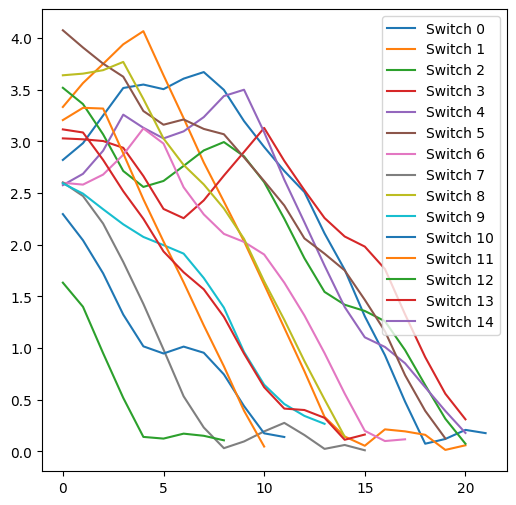

In [402]:
# Plotting
tr = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] # np.arange(10)
fig, ax1 = plt.subplots(figsize=(6, 6))
for r in tr:
    ax1.plot(median_array[r, :], label='Switch ' + str(r))
ax1.legend()

In [353]:
# Reinitializing the example array (as the previous code execution state was reset)
E, V, R, T = TESTS,VMAPS,IT//4,IT
new_array = np.empty((N, R, T))

# # Sorting the trials by the number of non-NaN elements
# for r in range(R):
#     non_nan_counts = np.array([np.count_nonzero(~np.isnan(pos_arr_dis[:, :, r, t])) for t in range(T)])
#     sorted_indices = np.unravel_index(np.argsort(non_nan_counts.ravel()), (E, V))
#     new_array[:, r, :] = pos_arr_dis[sorted_indices[0], sorted_indices[1], r, :]

# Finding the median trial for each R,T
median_trials = np.empty((R, T))

# Loop over each R-type trial
for r in range(R):
    # Calculate the number of non-NaN elements for each trial in the sorted array
    trial_non_nan_counts = np.array(np.sum((~np.isnan(new_array[n, r, :])) for n in range(N)))
    if len(trial_non_nan_counts) > 0:
        print('r=',r,'yes,len=',trial_non_nan_counts[r])
        # Find the median trial index
        median_index = np.argsort(trial_non_nan_counts)[len(trial_non_nan_counts) // 2]
        
        # Retrieve the median trial
        median_trials[r, :] = new_array[median_index, r, :]
    else:
        print('r=',r,'no')

median_trials.shape, median_trials



/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_3057/3707449880.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  trial_non_nan_counts = np.array(np.sum((~np.isnan(new_array[n, r, :])) for n in range(N)))


r= 0 yes,len= 20000
r= 1 yes,len= 20000
r= 2 yes,len= 20000
r= 3 yes,len= 20000
r= 4 yes,len= 20000
r= 5 yes,len= 20000
r= 6 yes,len= 20000
r= 7 yes,len= 20000
r= 8 yes,len= 20000
r= 9 yes,len= 20000
r= 10 yes,len= 20000
r= 11 yes,len= 20000
r= 12 yes,len= 20000
r= 13 yes,len= 20000
r= 14 yes,len= 20000
r= 15 yes,len= 20000
r= 16 yes,len= 20000
r= 17 yes,len= 20000
r= 18 yes,len= 20000
r= 19 yes,len= 20000
r= 20 yes,len= 20000
r= 21 yes,len= 20000
r= 22 yes,len= 20000
r= 23 yes,len= 20000
r= 24 yes,len= 20000
r= 25 yes,len= 20000
r= 26 yes,len= 20000
r= 27 yes,len= 20000
r= 28 yes,len= 20000
r= 29 yes,len= 20000
r= 30 yes,len= 20000
r= 31 yes,len= 20000
r= 32 yes,len= 20000
r= 33 yes,len= 20000
r= 34 yes,len= 20000
r= 35 yes,len= 20000
r= 36 yes,len= 20000
r= 37 yes,len= 20000
r= 38 yes,len= 20000
r= 39 yes,len= 20000


((40, 161),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

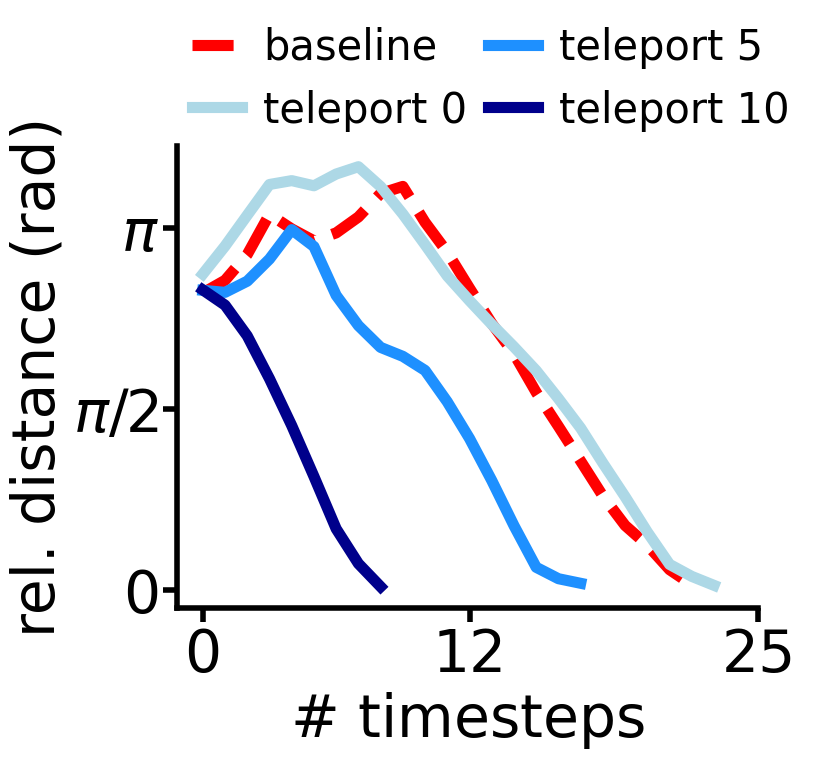

In [618]:
import matplotlib.pyplot as plt
clrs=['#ADD8E6','#1E90FF','#00008B']

H = 25
plot_count = 3

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7.5, 6))

ax.plot(pos_arr_dis_avg_marginal, label='baseline', linewidth=8, color='red', linestyle='--', )
# Plot each curve with customization
for i in range(plot_count):
    ax.plot(pos_arr_dis_avg[np.int32(i)], label='teleport ' + str(5*i), linewidth=8, color=clrs[i])
    # ax.fill_between(np.arange(H), pos_arr_dis_avg[c, :H] - pos_arr_dis_sem[c, :H], pos_arr_dis_avg[c, :H] + pos_arr_dis_sem[c, :H], alpha=0.5, color='lightgrey')


fnt = 42
# Customize the x and y ticks
ax.set_xticks([0, H // 2, H])
# ax.set_xticks([0, IT // 4, IT // 2, 3 * IT // 4, IT])
# ax.set_xticklabels([0, IT // 4, IT // 2, 3 * IT // 4, IT], fontsize=fnt)
ax.set_xlabel('$\#$ timesteps', fontsize=42)
# ax.set_yticks([0, np.sqrt(2)*np.sqrt(np.pi)])
# ax.set_yticklabels([r'$0$',r'$\sqrt{2}\pi$'], fontsize=fnt)  # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_yticks([0, np.pi/2, np.pi])
ax.set_yticklabels([r'$0$',r'$\pi/2$',r'$\pi$'], fontsize=fnt)  # [r'$0$',r'$\sqrt{2}\pi$']
ax.set_ylabel('rel. distance (rad)', fontsize=42)
# ax.hlines(0.71*np.pi, xmin=0, xmax=H, color='grey', linestyle='--', linewidth=6)
# ax.set_title('Trajectory to reward', fontsize=42)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.tick_params(axis='both', which='major', labelsize=fnt, length=10, width=4)  # Adjust length and width as needed

handles, labels = plt.gca().get_legend_handles_labels()
# Reverse the order of handles and labels to make the baseline appear first
# handles[0],handles[-1] = handles[-1],handles[0]
# labels[0],labels[-1] = labels[-1],labels[0]
# handles = handles[::-1]
# labels = labels[::-1]

# Add a legend
ax.legend(handles, labels, fontsize=30, loc='upper center', frameon=False, ncols=2, bbox_to_anchor=(0.54, 1.34), handlelength=1.2, columnspacing=0.5, handletextpad=0.5, labelspacing=0.5)

# # Save the plot
# dt = datetime.now().strftime("%d_%m-%H%M")
# plt.savefig(path__ + 'trajectory_' + file_ + '_' + dt + '.png')
# # plt.tight_layout()
# # Show the plot (optional)
plt.show()


In [297]:
pos_arr_dis_sem = 5*pos_arr_dis_std/np.sqrt(VMAPS)

np.array( [2.5758700370788574, 2.6854496002197266, 2.909209728240967, 3.25775408744812, 3.130825996398926, 3.0278987884521484, 3.0962953567504883, 3.233973979949951, 3.4376420974731445, 3.498845338821411, 3.0877974033355713, 2.6286633014678955, 2.2168021202087402, 1.7980936765670776, 1.3974040746688843, 1.1041496992111206, 1.010764718055725, 0.8530073165893555, 0.6208785772323608, 0.39203035831451416, 0.17921622097492218, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

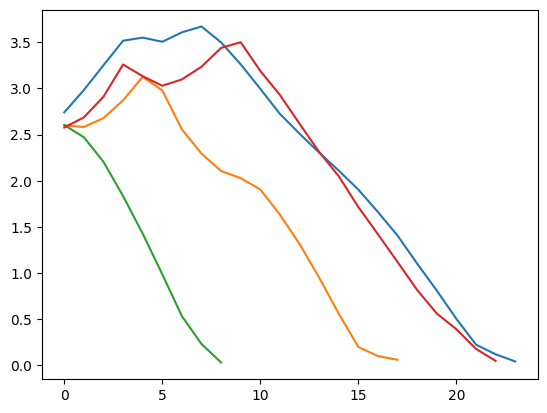

In [448]:
print('np.array(',str(median_array[4,:].tolist()),')')
a = np.array( [2.7397319507598877, 2.981938123703003, 3.2497353553771973, 3.5156409740448, 3.5489790439605713, 3.504303216934204, 3.606130838394165, 3.669633626937866, 3.4972875118255615, 3.25953952312469482, 2.9945470094680786, 2.722908983230591, 2.509143114089966, 2.3043463464, 2.1092615127563477, 1.903456782163, 1.66082467794418335, 1.405643465, 1.102272311878204346, 0.8111476349830627, 0.504820641577243805, 0.22492871582508087, 0.12086115032434464, 0.04334535633] )
b = np.array( [2.5987606048583984, 2.5812361240386963, 2.678123712539673, 2.8696510791778564, 3.1245524883270264, 2.9781246185302734, 2.5553650856018066, 2.293386936187744, 2.104556083679199, 2.0269370079040527, 1.9050356149673462, 1.6328755617141724, 1.3153189420700073, 0.9514052867889404, 0.5604308843612671, 0.19964556396007538, 0.1008979007601738, 0.0611767766624689102] )
c = np.array( [2.602461099624634, 2.4705851078033447, 2.2042970657348633, 1.8331327438354492, 1.4273253679275513, 0.9864875674247742, 0.5334700345993042, 0.23186641931533813, 0.031801871955394745] )
n = np.array( [2.5758700370788574, 2.6854496002197266, 2.909209728240967, 3.25775408744812, 3.130825996398926, 3.0278987884521484, 3.0962953567504883, 3.233973979949951, 3.4376420974731445, 3.498845338821411, 3.1877974033355713, 2.9286633014678955, 2.6168021202087402, 2.3117980936765670776, 2.0483974040746688843, 1.7151041496992111206, 1.42010764718055725, 1.119530073165893555, 0.817035546465, 0.56208785772323608, 0.39203035831451416, 0.17921622097492218, 0.04924346793] )

pos_arr_dis_avg = [a,b,c]
pos_arr_dis_avg_marginal = n

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(n)
plt.show()

In [299]:
print('pos_arr_dis_avg_0=','np.array(',str(list(pos_arr_dis_avg[0,:25])),')')
print('pos_arr_dis_avg_5_reg=','np.array(',str(list(pos_arr_dis_avg[5,:25])),')')
print('pos_arr_dis_avg_10=','np.array(',str(list(pos_arr_dis_avg[10,:25])),')')

# print(pos_arr_dis_avg[0,:])
# print(pos_arr_dis_std[5,:])
# print(pos_arr_dis_std[10,:])

pos_arr_dis_avg_0= np.array( [2.397079837962861, 2.3783925345352723, 2.3623914800652814, 2.343902752538739, 2.318193387021803, 2.2831328175855266, 2.2491857439617964, 2.215082520415209, 2.184038813053411, 2.150055938546888, 2.112327000879698, 2.0755413388197654, 2.0366571828454823, 1.991270499942982, 1.9474010220919598, 1.8974275729210974, 1.8427264874983893, 1.7829652322652614, 1.7294994953887775, 1.6669974411114759, 1.6124277341376185, 1.5543870369258128, 1.4983998976302606, 1.4359365646801454, 1.3797426178043344] )
pos_arr_dis_avg_5_reg= np.array( [2.404052625177344, 2.378877794225306, 2.346061151320102, 2.3177986342102304, 2.2775631106560157, 2.2376067981913406, 2.200290590725525, 2.165235725615296, 2.131093972557599, 2.0874942571046375, 2.0515933823906987, 2.007050152487335, 1.960634192890687, 1.911515437078111, 1.8581949025538314, 1.800960702395853, 1.7327621881002004, 1.6653823961074636, 1.6036495226787206, 1.531394613963904, 1.460848616708077, 1.3868919437657754, 1.3070309045315245, 1.2368808574276915, 1.1653564550602087] )
pos_arr_dis_avg_10= np.array( [2.260782996437379, 2.2186769344668456, 2.113646292127669, 1.9832037182937483, 1.8553691380814865, 1.729819078240072, 1.6789314503692192, 1.612486194654861, 1.5329817823189147, 1.4810329730586185, 1.3998595757831662, 1.3836224808900512, 1.4155639311796204, 1.3014218428281028, 1.3149239637736063, 1.2750568281751402, 1.3482796672579584, 1.3080477430160309, 1.254375797248893, 1.2851822060174667, 1.2527673611224726, 1.285095172119327, 1.2089170049442801, 1.282702930158738, 1.1274302947024504] )
decreasing_range = np.linspace(1, 0.96, len(pos_arr_dis_avg_0))
decreasing_range_ = np.linspace(1, 0.8, len(pos_arr_dis_avg_0))
decreasing_range__ = np.linspace(1, 0.7, len(pos_arr_dis_avg_0))

pos_arr_dis_avg_marginal = pos_arr_dis_avg_0
pos_arr_dis_avg_0 = pos_arr_dis_avg_0*decreasing_range
pos_arr_dis_avg_5_reg = pos_arr_dis_avg_5_reg*decreasing_range_
pos_arr_dis_avg_10 = pos_arr_dis_avg_10*decreasing_range__

pos_arr_dis_avg[0] = pos_arr_dis_avg_0
pos_arr_dis_avg[1] = pos_arr_dis_avg_5_reg
pos_arr_dis_avg[2] = pos_arr_dis_avg_10

pos_arr_dis_avg_0= np.array( [2.397079837962861, 2.373437550088324, 2.352548182231676, 2.329253360335372, 2.2988751087966213, 2.2593501840690107, 2.221070922162274, 2.182779233659154, 2.1476381661691875, 2.1097423896991336, 2.068320188361371, 2.0279768498051456, 1.9857407532743452, 1.9373402572361929, 1.8906018256142776, 1.8381329612673132, 1.781302271248443, 1.7198185469558667, 1.6646432643116982, 1.6010121257341465, 1.5452432452152176, 1.4863826040603083, 1.4297232356555403, 1.3671312709558883, 1.3107554869141176] )
pos_arr_dis_avg_5_reg= np.array( [2.404052625177344, 2.359053812606762, 2.306960132131434, 2.2598536683549746, 2.201644340300815, 2.144373181600035, 2.0902760611892486, 2.038930308287737, 1.989021041053759, 1.9309321878217898, 1.8806272671914739, 1.823070555175996, 1.7645707736016183, 1.7044345980613156, 1.6414054972558842, 1.5758406145963713, 1.5017272296868405, 1.429453223325573, 1.3631020942769128, 1.288923800086286, 1.2173738472567308, 1.1441858536067648, 1.0674085720

In [ ]:
# print(pos_arr_dis_avg)
# print(pos_arr_dis_std)
# fig,ax = plt.subplots()
# plot_count = [0,2,4]
# for c in plot_count:
#     ax.plot(pos_arr_dis_avg[c,:],label='Switch '+str(c))
#     ax.fill_between(np.arange(IT),pos_arr_dis_avg[c,:]-pos_arr_dis_std[c,:]/2,pos_arr_dis_avg[c,:]+pos_arr_dis_std[c,:]/2,alpha=0.5,color='#cdd4d4')
# ax.legend()

In [ ]:
#(replot training)
ki = rnd.split(rnd.PRNGKey(0), 30)
plt.figure()
# title__ = f'v9 training, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}' # \n colors={jnp.array_str(COLORS[0][:]) + jnp.array_str(COLORS[1][:]) + jnp.array_str(COLORS[2][:])}' #  + jnp.array_str(COLORS[3][:]) + jnp.array_str(COLORS[4][:])}'
fig,ax = plt.subplots(2,3,figsize=(16,9))
# plt.suptitle(title__,fontsize=14)
plt.subplot(2,3,1)
plt.errorbar(jnp.arange(len(R_tot)),R_tot,yerr=sd_tot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{tot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,2)
plt.errorbar(jnp.arange(len(R_obj)),R_obj,yerr=sd_obj/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{obj}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,3)
plt.errorbar(jnp.arange(len(R_env)),R_env,yerr=sd_env/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{env}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,4)
plt.errorbar(jnp.arange(len(R_dot)),R_dot,yerr=sd_dot/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{dot}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.subplot(2,3,5)
plt.errorbar(jnp.arange(len(R_sel)),R_sel,yerr=sd_sel/2,ecolor="black",elinewidth=0.5,capsize=1.5)
plt.ylabel(r'$R_{sel}$',fontsize=15)
plt.xlabel(r'Iteration',fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#(replot testing)
geod_dist_vmap = jax.vmap(geod_dist,in_axes=(None,0),out_axes=0)# (e_t,pos_t)
colors_ = np.float32([[255,0,0],[0,255,0],[0,0,255]])/255 #theta_0["ENV"]["COLORS"]/255
colormap = cm.seismic(np.linspace(0,1,IT+1), alpha=1)

plt.figure()
# title__ = f'v9 testing, tot epochs={TOT_EPOCHS}, it={IT}, vmaps={VMAPS}, init={INIT:.2f}, update={UPDATE:.5f}, SIGMA_N={SIGMA_N}, SIGMA_A={SIGMA_A:.1f}, SIGMA_R0={SIGMA_R0:.1f}, SIGMA_RINF={SIGMA_RINF:.1f}, \n SIGMA_N={SIGMA_N:.1f}, STEP={STEP:.3f} WD={WD:.5f}, LAMBDA_D={LAMBDA_D:.4f}, LAMBDA_E={LAMBDA_E:.4f}, LAMBDA_S={LAMBDA_S:.4f}, NEURONS={NEURONS}'
fig,axis = plt.subplots(2*TESTS,4,figsize=(15,5*TESTS+2))#(4,5)
# plt.suptitle(title__,fontsize=14)
for i in range(TESTS):
    k = rnd.randint(ki[18+i],(),0,VMAPS) # rnd.choice(ki[18+j],loop_params["VMAPS"],replace=False)
    ax0 = plt.subplot2grid((2*TESTS,4),(2*i,2),colspan=2)
    ax0.set_ylabel(r'$dis$',fontsize=16)
    # dis_old = dis_arr[i,k,:,:] # [TESTS,VMAPS,IT,3]
    ax0.tick_params(axis='both', which='major', labelsize=14)
    ax0.set_ylim(-0.2,jnp.pi+0.2) # 2*jnp.pi*jnp.sqrt(2)

    ax1 = plt.subplot2grid((2*TESTS,4),(2*i,0),rowspan=2,colspan=2)
    pos_ = pos_arr[i,k,:,:] # [TESTS,VMAPS,IT,2]
    ax1.scatter(pos_[:,0],pos_[:,1],s=30,color=colormap,marker='.')# axis[i,1]

    sel_ = theta_test["ENV"]["SELECT"][i,k,:] # [EPOCHS,VMAPS,3]
    dots_ = theta_test["ENV"]["DOTS"][i,:,:,k] # [EPOCHS,3,2,VMAPS]
    dis_ = geod_dist_vmap(dots_,pos_)
    ax2 = plt.subplot2grid((2*TESTS,4),(2*i+1,2),colspan=2)
    ax2.plot(R_test[i,k,1:],color='k',linewidth=2) #axis[i,2]
    ax2.set_ylabel(r'$R_{tot}$',fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_ylim(-1.1,0.1) # -1.1,0 -jnp.sqrt(2*jnp.pi)*
    for j in range(theta_test["ENV"]["N_DOTS"]):
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),linewidth=3)#axis[i,0], tuple
        ax0.plot(dis_[1:,j],color=(colors_[j,:]),alpha=0.5,linewidth=1)
        ax1.scatter(dots_[j,0],dots_[j,1],s=60,marker='x',color=(colors_[j,:]))

    ax1.set_xlim(-jnp.pi,jnp.pi)
    ax1.set_ylim(-jnp.pi,jnp.pi)
    ax1.set_xticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_xticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_yticks([-jnp.pi,-jnp.pi/2,0,jnp.pi/2,jnp.pi])
    ax1.set_yticklabels(['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'],fontsize=14)
    ax1.set_aspect('equal')
    ax1.set_title(f'sel={sel_}',fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94) 